In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
from os import path
import json

import polars as pl
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

In [2]:
label_encoder = LabelEncoder()

def load_data(filename, fit=True):
    path = os.path.join("..", "data_workflow_notebooks", "data", "tabular", filename)
    data = pl.read_csv(path).to_numpy()

    # 2nd last column is target, last column is file name
    x = data[:, :-2].astype(float)
    y_raw = data[:, -2]
    if fit:
        y = label_encoder.fit_transform(y_raw)
    else:
        y = label_encoder.transform(y_raw)
    return x, y

X_train, y_train = load_data("train_processed.csv", fit=True)
X_test, y_test = load_data("test_processed.csv")

print(f"Data loaded successfully\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

Data loaded successfully
Train shape: (5621, 106), Test shape: (301, 106)


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
pca = PCA().fit(X_train_scaled)
exp_var = pca.explained_variance_ratio_
cum_var = exp_var.cumsum()
n_components = next(i for i, v in enumerate(cum_var) if v >= 0.95) + 1
print(f"Intrinsic dimensionality (95% variance): {n_components}")

Intrinsic dimensionality (95% variance): 53


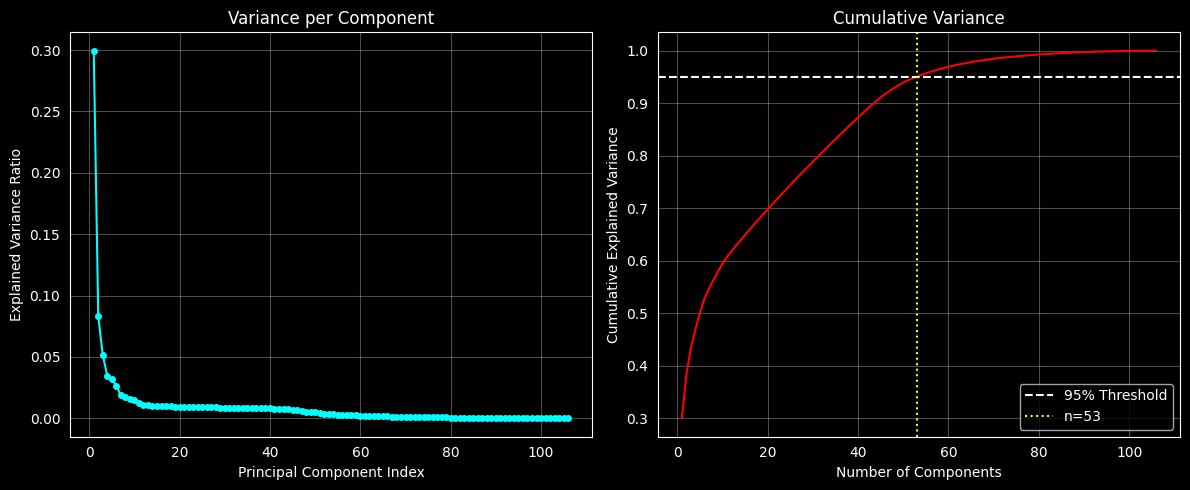

In [5]:
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, len(exp_var) + 1), exp_var, 'o-', color='cyan', markersize=4)
ax1.set_xlabel('Principal Component Index')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Variance per Component')
ax1.grid(alpha=0.3)

ax2.plot(range(1, len(cum_var) + 1), cum_var, 'r-')
ax2.axhline(y=0.95, color='white', linestyle='--', label='95% Threshold')
ax2.axvline(x=n_components, color='yellow', linestyle=':', label=f'n={n_components}')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

X_recon = pca_final.inverse_transform(X_train_pca)
recon_error = ((X_train_scaled - X_recon) ** 2).mean()
print(f"Reconstruction Error: {recon_error}")

Reconstruction Error: 0.049415784613499374


In [7]:
# Benchmark config copied from task_1/library_benchmark.ipynb
configs = {
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('clf', LogisticRegression(max_iter=2000))
        ]),
        'params': {
            'clf__C': [0.1, 0.5, 1, 5, 10],
            'clf__solver': ['lbfgs', 'newton-cg']
        }
    },

    'Log. Reg. (Non-Linear)': {
        'pipeline': Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('clf', LogisticRegression(max_iter=50000))
        ]),
        'params': {
            'clf__C': [0.001, 0.01, 0.1, 1]
        }
    },

    'SVM (Linear)': {
        'pipeline': Pipeline([
            ('clf', SVC(kernel='linear', max_iter=500000))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1]
        }
    },

    'SVM (Kernel RBF)': {
        'pipeline': Pipeline([
            ('clf', SVC(kernel='rbf', max_iter=10000))
        ]),
        'params': {
            'clf__C': [20, 50, 100, 150, 200],
            'clf__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01]
        }
    },

    'k-NN': {
        'pipeline': Pipeline([
            ('clf', KNeighborsClassifier(weights='distance'))
        ]),
        'params': {
            'clf__n_neighbors': [5, 7, 11, 15, 25],
            'clf__p': [1, 2],
            'clf__leaf_size': [1, 2, 3, 5, 7]
        }
    },

    'Naive Bayes': {
        'pipeline': Pipeline([
            ('clf', GaussianNB())
        ]),
        'params': {
            'clf__var_smoothing': [1e-4, 1e-3, 0.01, 0.1]
        }
    },

    'Random Forest': {
        'pipeline': Pipeline([
            ('clf', RandomForestClassifier(random_state=462))
        ]),
        'params': {
            'clf__n_estimators': [100, 200, 250, 300, 400],
            'clf__max_depth': [None, 10, 20, 25, 30, 40]
        }
    }
}

In [8]:
results_pca = []

for name, config in configs.items():
    print(f"Training {name} (PCA)")
    grid = GridSearchCV(
            config['pipeline'],
            config['params'],
            cv=5,
            n_jobs=-1,
            scoring='accuracy'
        )

    start_time = time.time()
    grid.fit(X_train_pca, y_train)
    training_time = time.time() - start_time

    y_pred = grid.best_estimator_.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    results_pca.append({
        'Classifier': name,
        'Best Hyperparameters': json.dumps(grid.best_params_),
        'Training Time (sec)': round(training_time, 4),
        'Test Accuracy': f"{round(acc * 100, 2)} %"
    })

Training Logistic Regression (PCA)
Training Log. Reg. (Non-Linear) (PCA)
Training SVM (Linear) (PCA)
Training SVM (Kernel RBF) (PCA)
Training k-NN (PCA)
Training Naive Bayes (PCA)
Training Random Forest (PCA)


In [9]:
pl.Config.set_fmt_str_lengths(1000)
results_pca_df = pl.DataFrame(results_pca)
display(results_pca_df.sort(by="Test Accuracy", descending=True))
results_pca_df.write_csv('benchmark_results_pca.csv')

Classifier,Best Hyperparameters,Training Time (sec),Test Accuracy
str,str,f64,str
"""SVM (Linear)""","""{""clf__C"": 0.1}""",0.8816,"""96.35 %"""
"""Logistic Regression""","""{""clf__C"": 5, ""clf__solver"": ""lbfgs""}""",4.4606,"""96.01 %"""
"""SVM (Kernel RBF)""","""{""clf__C"": 150, ""clf__gamma"": 0.001}""",6.6268,"""93.69 %"""
"""Random Forest""","""{""clf__max_depth"": 25, ""clf__n_estimators"": 300}""",124.4932,"""87.71 %"""
"""Naive Bayes""","""{""clf__var_smoothing"": 0.001}""",0.1399,"""84.05 %"""
"""Log. Reg. (Non-Linear)""","""{""clf__C"": 0.01}""",45.8185,"""81.73 %"""
"""k-NN""","""{""clf__leaf_size"": 1, ""clf__n_neighbors"": 15, ""clf__p"": 1}""",2.6024,"""77.41 %"""


In [10]:
old_results = pl.read_csv(path.join('..', 'task_1' , 'benchmark_results.csv'))
comparison = old_results.join(results_pca_df, on="Classifier", suffix="_pca")

In [11]:
def parse_acc(acc_str):
    return float(acc_str.replace(' %', ''))

comparison = comparison.with_columns(
    (pl.col("Test Accuracy_pca").map_elements(parse_acc, return_dtype=pl.Float64) -
     pl.col("Test Accuracy").map_elements(parse_acc, return_dtype=pl.Float64)).alias("Score Diff")
)
display(comparison.select([
    "Classifier",
    pl.col("Best Hyperparameters").alias("Old Params"),
    pl.col("Best Hyperparameters_pca").alias("New Params"),
    pl.col("Test Accuracy").alias("Old Score"),
    pl.col("Test Accuracy_pca").alias("New Score"),
    "Score Diff"
]))

Classifier,Old Params,New Params,Old Score,New Score,Score Diff
str,str,str,str,str,f64
"""Logistic Regression""","""{""clf__C"": 0.5, ""clf__solver"": ""lbfgs""}""","""{""clf__C"": 5, ""clf__solver"": ""lbfgs""}""","""92.36 %""","""96.01 %""",3.65
"""Log. Reg. (Non-Linear)""","""{""clf__C"": 0.1}""","""{""clf__C"": 0.01}""","""66.11 %""","""81.73 %""",15.62
"""SVM (Linear)""","""{""clf__C"": 0.1}""","""{""clf__C"": 0.1}""","""89.37 %""","""96.35 %""",6.98
"""SVM (Kernel RBF)""","""{""clf__C"": 150, ""clf__gamma"": 0.001}""","""{""clf__C"": 150, ""clf__gamma"": 0.001}""","""85.05 %""","""93.69 %""",8.64
"""k-NN""","""{""clf__leaf_size"": 1, ""clf__n_neighbors"": 11, ""clf__p"": 1}""","""{""clf__leaf_size"": 1, ""clf__n_neighbors"": 15, ""clf__p"": 1}""","""33.55 %""","""77.41 %""",43.86
"""Naive Bayes""","""{""clf__var_smoothing"": 0.01}""","""{""clf__var_smoothing"": 0.001}""","""87.71 %""","""84.05 %""",-3.66
"""Random Forest""","""{""clf__max_depth"": 20, ""clf__n_estimators"": 200}""","""{""clf__max_depth"": 25, ""clf__n_estimators"": 300}""","""81.4 %""","""87.71 %""",6.31
